In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# 1. Load Data

In [4]:
# For Jupyter, use a direct relative or absolute path 
CSV_PATH = "../../results/fepls_stats.csv"

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Could not find stats file at {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} pairs.")
df.head()

Loaded 544 pairs.


,X,Y,best_k,max_corr,sharpness,n_samples
0,akko,vertikal,5,0.956045,0.000000,103
1,any,vertikal,5,0.902423,0.000000,103
2,appeninn,akko,5,0.881637,0.000000,103
3,cigpannonia,opus,6,0.824400,0.140261,102
4,waberers,opus,6,0.819089,0.163514,103


# 2. Summary Statistics

In [5]:
print("--- Summary Statistics ---")
print(df[['best_k', 'max_corr', 'sharpness']].describe())

--- Summary Statistics ---
           best_k    max_corr   sharpness
count  544.000000  544.000000  544.000000
mean     9.238971    0.396430    0.213216
std      4.250649    0.146090    0.208696
min      5.000000    0.068227    0.000000
25%      6.000000    0.296744    0.000000
50%      8.000000    0.394092    0.171639
75%     12.000000    0.483510    0.330950
max     19.000000    0.956045    0.972421


# 3. Distributions

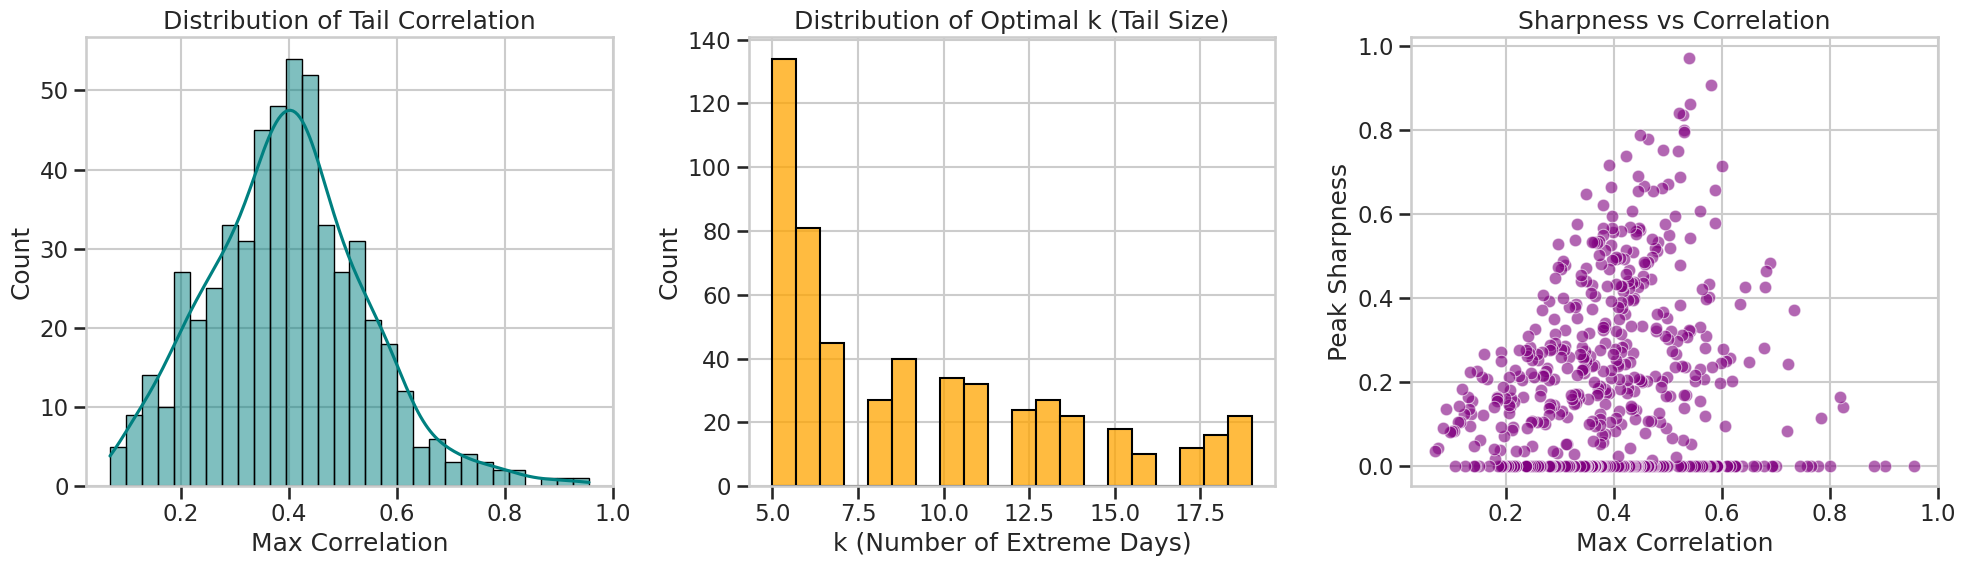

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Max Correlation Distribution
sns.histplot(df['max_corr'], bins=30, kde=True, ax=axes[0], color='teal')
axes[0].set_title('Distribution of Tail Correlation')
axes[0].set_xlabel('Max Correlation')

# Best k Distribution
sns.histplot(df['best_k'], bins=20, kde=False, ax=axes[1], color='orange')
axes[1].set_title('Distribution of Optimal k (Tail Size)')
axes[1].set_xlabel('k (Number of Extreme Days)')

# Sharpness vs Correlation
sns.scatterplot(data=df, x='max_corr', y='sharpness', alpha=0.6, ax=axes[2], color='purple')
axes[2].set_title('Sharpness vs Correlation')
axes[2].set_xlabel('Max Correlation')
axes[2].set_ylabel('Peak Sharpness')

plt.tight_layout()
plt.show()

# 4. Network Analysis: Who are the Key Players?

In [7]:
# Define "High Correlation" threshold (Top 10%)
threshold = df['max_corr'].quantile(0.90)
high_corr_df = df[df['max_corr'] >= threshold]

print(f"\nAnalyzing Top 10% Pairs (Correlation >= {threshold:.2f})")

# Most Frequent Predictors (Systemic Sources of Risk?)
top_predictors = high_corr_df['X'].value_counts().head(10)
print("\nTop Risk Predictors (Most frequent X in high corr pairs):")
print(top_predictors)

# Most Frequent Targets (Most Fragile Stocks?)
top_targets = high_corr_df['Y'].value_counts().head(10)
print("\nTop Risk Targets (Most frequent Y in high corr pairs):")
print(top_targets)


Analyzing Top 10% Pairs (Correlation >= 0.58)

Top Risk Predictors (Most frequent X in high corr pairs):
X
alteo          5
mol            5
waberers       5
any            4
otp            4
dunahouse      4
appeninn       3
masterplast    3
autowallis     3
4ig            3
Name: count, dtype: int64

Top Risk Targets (Most frequent Y in high corr pairs):
Y
opus           11
vertikal        6
akko            6
mol             4
bif             4
cigpannonia     3
otp             3
any             3
autowallis      2
pannergy        2
Name: count, dtype: int64


# 5. Sector Analysis (Heuristic)

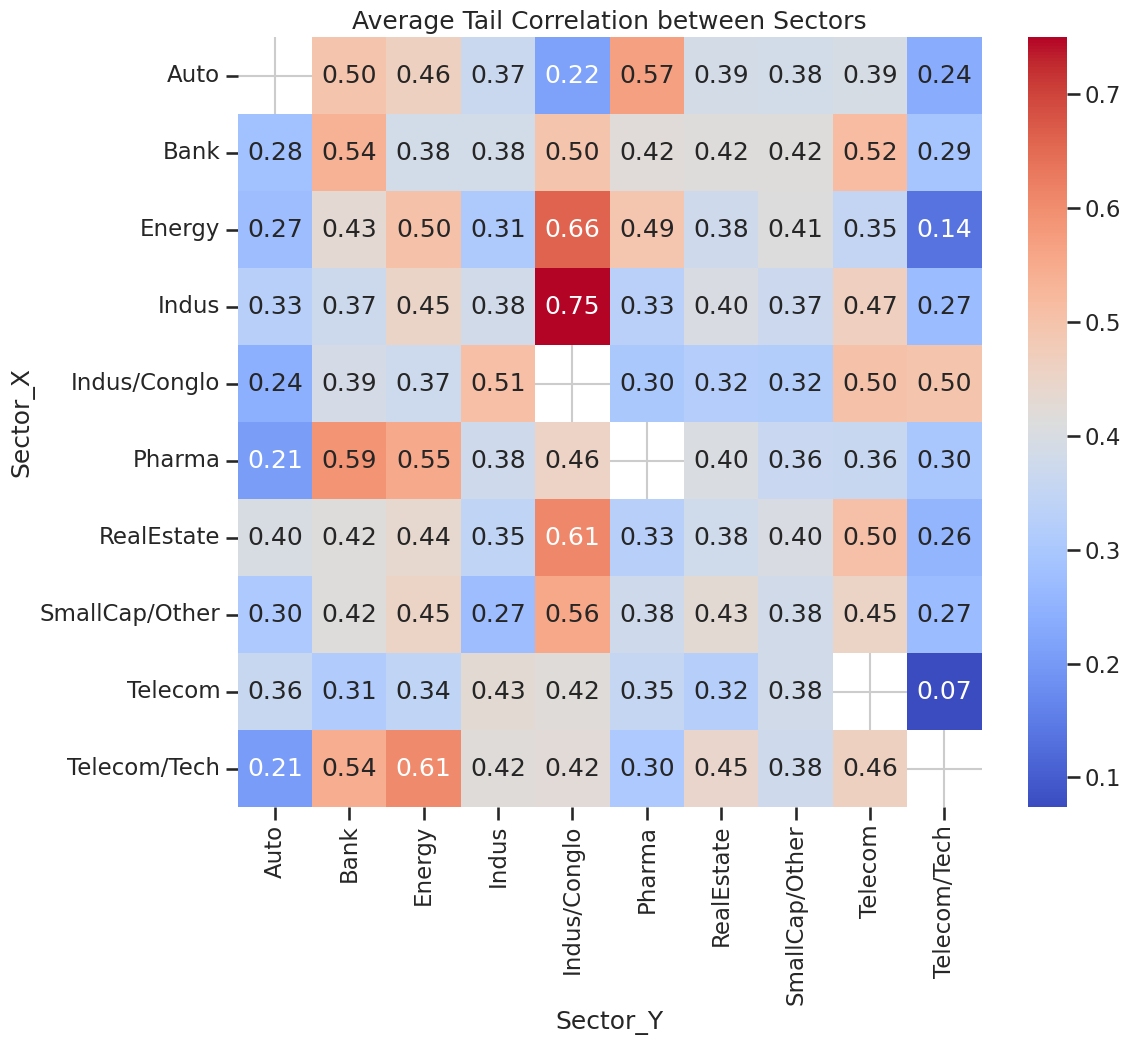

In [8]:
# Simple mapping based on known BSE stocks
sector_map = {
    'otp': 'Bank', 'mbhbank': 'Bank', 'granit': 'Bank',
    'mol': 'Energy', 'alteo': 'Energy', 'pannergy': 'Energy',
    'richter': 'Pharma', 'egis': 'Pharma',
    'mtelekom': 'Telecom', '4ig': 'Telecom/Tech',
    'opus': 'Indus/Conglo', 'masterplast': 'Indus', 'raba': 'Auto',
    'appeninn': 'RealEstate', 'bif': 'RealEstate', 'dunahouse': 'RealEstate',
    'graphisoft': 'Tech',
    'any': 'Indus'
}

def get_sector(ticker):
    # Ticker format is usually 'name' from 'name.hu.txt'
    # We cleaned it in the previous script to just 'name'
    return sector_map.get(ticker, 'SmallCap/Other')

df['Sector_X'] = df['X'].apply(get_sector)
df['Sector_Y'] = df['Y'].apply(get_sector)

# Create a Sector-to-Sector Heatmap of Average Max Correlation
sector_heatmap = df.pivot_table(index='Sector_X', columns='Sector_Y', values='max_corr', aggfunc='mean')

plt.figure(figsize=(12, 10))
sns.heatmap(sector_heatmap, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Tail Correlation between Sectors')
plt.show()

# 6. The "Black Swan" Candidates
Pairs with very low k (<= 7) AND very high correlation (> 0.8)
These are rare but extremely synchronized events.

In [9]:
black_swans = df[(df['best_k'] <= 7) & (df['max_corr'] > 0.8)].sort_values('max_corr', ascending=False)
print(f"\nFound {len(black_swans)} 'Black Swan' pairs (Low k, High Corr):")
print(black_swans[['X', 'Y', 'best_k', 'max_corr']])


Found 5 'Black Swan' pairs (Low k, High Corr):
             X         Y  best_k  max_corr
0         akko  vertikal       5  0.956045
1          any  vertikal       5  0.902423
2     appeninn      akko       5  0.881637
3  cigpannonia      opus       6  0.824400
4     waberers      opus       6  0.819089
